# Optimization using the Problem class

This notebook will show the basics of setting up a resilience optimization problem with the `Problem` class in `fmdtools.faultsim.search` module.

In [1]:
import sys, os
sys.path.insert(0,os.path.join('..'))
from fmdtools.faultsim.search import Problem
from pump_stochastic import Pump

The `Problem` class can be used to define an optimization problem around and fmdtools model/simulation in terms of variables, objectives, and constraints. See below:

In [2]:
print(Problem.__doc__)


    Interface for resilience optimization problems. 
    
    Attributes
    ----------
        simulations : dict
            Dictionary of simulations and their corresponding arguments
        variables : list
            List of variables and their properties
        objectives : dict
            Dictionary of objectives and their times/arguments
        constraints : dict
            Dictionary of constraints and their times/arguments
        current_iter : dict
            Dictionary of current values for variables/objectives/constraints/etc.
    


The problem class has many of the same objects as the methods in the `faultsim.propagate` module:

In [3]:
help(Problem.__init__)

Help on function __init__ in module fmdtools.faultsim.search:

__init__(self, name, mdl, default_params={}, negative_form=True, **kwargs)
    Instantiates the Problem object.
    
    Parameters
    ----------
    
    name : str
        Name for the problem
    mdl : Model
        Model to optimize
    negative_form : bool
        Whether constraints are negative when feasible (True) or positive when feasible (False)
    default_params : dict
        Default parameters for the model
    **kwargs : kwargs
        Default run kwargs. See :data:`sim_kwargs`, :data:`run_kwargs`, :data:`mult_kwargs`



Below we send the pump model and specify to simulate it using the `staged` option (which should be much faster to iterate over).

In [4]:
mdl=Pump()
new_problem = Problem("new_problem", mdl, staged=True, negative_form=False)

Next, a simulation is added to the `Problem` using `Problem.add_simulation`

In [5]:
help(Problem.add_simulation)

Help on function add_simulation in module fmdtools.faultsim.search:

add_simulation(self, simname, simtype, *args, **kwargs)
    Defines a simulation to be used with the model
    
    Parameters
    ----------
    simname : str
        Name/identifier for the simulation.
    simtype : str, optional
        Type of simulation(s) to run (aligns with propagate methods):
            - single:      simulates a single scenario (the default)
                - args: sequence: sequence defining fault scenario {time:{'faults':(fxn:mode), 'disturbances':{'Fxn1.var1'}})}
            - multi:       simulates multiple scenarios (provided approach or nominalapproach)
                - args: scenlist: dict with structure {"scenname":{'sequence':{"faults":{}, "disturbances":{}}, "properties":{"params":params}}}
                        (can be gotten from prop.list_init_faults, SampleApproach, or NominalApproach)
            - nested:      simulates nested scenarios (provided approach and nominalapproa

In this case, we will optimize over a single scenario, passing ``single`` as the simtype.

In [6]:
new_problem.add_simulation("test_sim","single", scen={26:{"faults":{"ImportEE": "no_v"}}})

Variables may then be added using `Problem.add_variables`. 

In [7]:
help(Problem.add_variables)

Help on function add_variables in module fmdtools.faultsim.search:

add_variables(self, simnames, *args, vartype='vars', t=0)
    Adds variable of specified type ('params', 'vars', or 'faults') to a given problem. 
    Also adds variable set constraints (if given)
    
    Parameters
    ----------
    simnames : str/list
        identifier for the simulation(s) the variable is optimized over
    *args : tuples
        variables to add, where each tuple has the form:
        (varname, set_const (optional), vartype (optional), t (optional)), where
        - varname is:
            an element of mdl.params (if vartype='params')
            a model variable (if vartype='vars')
            a function name (if vartype='faults')
        - set_const defines the variable set constraints, which may be:
            None (for none/inf)
            A two-element tuple (for continuous variable bounds)
            A multi-element list (for discrete variables)
        - vartype is the individual vari

In this case, we are optimizing a change in the `eff` parameter at time t=10. Note that using the `staged` option, this means that the model will be copied at this time and then simulated to the final simulation time.

This variable is also given the set constraint (bounds) of [0,5], which will show up in the `constraints` dictionary.

In [8]:
new_problem.add_variables("test_sim", ("MoveWater.eff", [0,5]), t=10)

We can further add objectives using `Problem.add_objectives`

In [9]:
help(Problem.add_objectives)

Help on function add_objectives in module fmdtools.faultsim.search:

add_objectives(self, simname, *args, objtype='endclass', t='end', obj_const='objectives', agg='sum', **kwargs)
    Adds objective to the given problem.
    
    Parameters
    ----------
    simname : str
        identifier for the simulation
    *args : strs/tuples
        variables to use as objectives (auto-named to f1, f2...)
        may take form: (variablename, objtype (optional), t (optional), agg (optional)) 
        or variablename, where variablename is the name of the variable (from params, mdlparams)
        or index of the callable (for external)and objtype, t, and agg may override
        the default objtype and t (see below)
    objtype : str (optional)
        default type of objective: `vars`, `endclass`, or `external`. Default is 'endclass'
    t : int (optional)
        default time to get objective: 'end' or set time t
    agg : str/tuple
        Specifies the aggregation of the objective/constrain

In this case, we are optimizing the total flow in the `MoveWater` function as read at time t=25. 

In [10]:
new_problem.add_objectives("test_sim", obj_1="MoveWater.total_flow", objtype='vars', t=25)

We can additionally add constraints to the problem, in this case power as read at t=25.

In [11]:
new_problem.add_constraints("test_sim", con_1 = "Wat_1.pressure", objtype='vars', t=11, threshold = ('less', 20))

Note that if all objectives and constraints are sampled in time before the defined simulation end-point, it will finish before completion to save computational time.


In [12]:
new_problem

Problem new_problem: 
 -vars MoveWater.eff at t=10: [0, 5]
 -obj_1: test_sim vars sum MoveWater.total_flow at t=25
 -con_1: test_sim vars Wat_1.pressure less than 20 at t=11: 
 -test_sim: single scen{26: {'faults': {'ImportEE': 'no_v'}}}
 Current Iteration: 
 -

Now that this problem is set up, we now have interfaces which can be passed to optimization methods. These are methods which *match the names of the objectives/constraints defined earlier* which can be passed as callables to optimizaiton methods.

In [13]:
new_problem.obj_1([1])

6.299999999999998

In [14]:
new_problem.obj_1([0])

1.5

In [15]:
new_problem.obj_1([2])

8.099999999999998

In [16]:
new_problem.con_1([1])

10.0

In [17]:
new_problem.con_1([10])

-80.0

Note that despite being different callables, to reduce simulation costs, `obj_1` and `con_1` only *simulate the model* when a new variable value is entered into the problem. This can be seen by looking at the `current_iter` dictionary, which updates at each new variable value:

In [25]:
new_problem

Problem new_problem: 
 -vars MoveWater.eff at t=10: [0, 5]
 -obj_1: test_sim vars sum MoveWater.total_flow at t=25
 -con_1: test_sim vars Wat_1.pressure less than 20 at t=11: 
 -test_sim: single scen{26: {'faults': {'ImportEE': 'no_v'}}}
 Current Iteration: 
 -vars: [1.49011736e-08]
 -objs: {'obj_1': 1.5000000715256334}
 -consts: {'con_1': 19.999999850988264, 'set_var_0_ub': 4.999999985098826, 'set_var_0_lb': 1.4901173628345532e-08}

Additionally, provided the tracking options are set to on, the `plot_obj_const` method enables rapid visualization of objectives, constraints, and variables (and where they are queried):

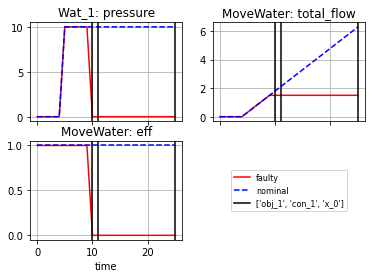

In [26]:
new_problem.plot_obj_const('test_sim')

Now, we will demonstrate optimization using this problem as it is set up:

In [27]:
from scipy.optimize import minimize

Note that scipy minimize assumes that:
- objectives are to be minimized, and
- constraints must be held positive 

The problem should thus be set up to accomodate this, by stating whether objectives should be positive/negative and by setting `negative_form=False`.

In [21]:
res = minimize(new_problem.obj_1, [1], constraints=new_problem.get_constraint_list())

In [28]:
res

     fun: 1.5000000000000604
     jac: array([4.79999995])
 message: 'Optimization terminated successfully'
    nfev: 4
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([1.24344979e-14])

As shown, the variables are optimized to a value of x=0.0, the minimum possible value of MoveWater.eff which was put in the problem. We can further verify the optimized result by looking at the problem:

In [29]:
new_problem

Problem new_problem: 
 -vars MoveWater.eff at t=10: [0, 5]
 -obj_1: test_sim vars sum MoveWater.total_flow at t=25
 -con_1: test_sim vars Wat_1.pressure less than 20 at t=11: 
 -test_sim: single scen{26: {'faults': {'ImportEE': 'no_v'}}}
 Current Iteration: 
 -vars: [1.49011736e-08]
 -objs: {'obj_1': 1.5000000715256334}
 -consts: {'con_1': 19.999999850988264, 'set_var_0_ub': 4.999999985098826, 'set_var_0_lb': 1.4901173628345532e-08}

As shown, the bound set constraint x>0 is active at the found minimum, as we would expect.

We can further visualize this solution using:

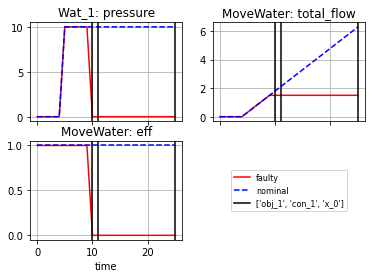

In [24]:
new_problem.plot_obj_const('test_sim')